In [165]:
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy

In [166]:
sns.set_theme(context='notebook', style='whitegrid')
sns.set_palette('Paired')

In [167]:
power_sources = ['Solar', 'Wind', 'Geothermal', 'Biomass',
       'Biogas', 'Small hydro', 'Coal', 'Nuclear', 'Natural Gas',
       'Large Hydro', 'Batteries', 'Imports']
other = ['Date', 'Time', 'DateTime', 'Month', 'Year']

In [168]:
df = pd.read_csv('caiso_2021-22.csv', date_parser=['Date', 'Time'])
df.drop(columns=['Other'], inplace=True)
df.Date = pd.to_datetime(df.Date)
df.Time = pd.to_datetime(df.Time)

In [169]:
df['Total power'] = df['Solar']
for ps in power_sources[1:]:
    df['Total power'] += df[ps]

In [170]:
df.describe()

,Unnamed: 0,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural Gas,Large Hydro,Batteries,Imports,Month,Year,Total power
count,105104.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105104.000000,105104.000000,105092.000000
mean,143.478231,4193.116555,2454.372731,869.873949,287.631047,200.969284,191.277966,12.498525,2076.552973,8614.644778,1457.924219,77.379268,5612.521467,6.526374,2021.665703,26048.762760
std,83.125935,5046.487510,1456.446929,76.966457,45.488711,14.678127,94.729647,4.994506,406.780691,3905.161266,855.182969,572.085363,2963.652848,3.447995,0.471747,4762.813769
min,0.000000,-180.000000,28.000000,474.000000,-278.000000,132.000000,46.000000,-6.000000,446.000000,1494.000000,-494.000000,-1848.000000,-4459.000000,1.000000,2021.000000,15916.000000
25%,71.000000,-33.000000,1200.000000,823.000000,255.000000,195.000000,153.000000,9.000000,2250.000000,5692.000000,878.000000,-234.000000,3395.000000,4.000000,2021.000000,22661.000000
50%,143.000000,170.000000,2211.000000,878.000000,288.000000,204.000000,190.000000,14.000000,2264.000000,8116.000000,1279.000000,3.000000,6208.000000,7.000000,2022.000000,25121.500000
75%,215.000000,9391.000000,3649.000000,903.000000,320.000000,211.000000,226.000000,17.000000,2268.000000,10828.000000,1908.000000,319.000000,7999.000000,10.000000,2022.000000,27983.250000
max,287.000000,14288.000000,6429.000000,1134.000000,412.000000,242.000000,3316.000000,91.000000,2287.000000,25441.000000,4556.000000,3053.000000,11587.000000,12.000000,2022.000000,46679.000000


<AxesSubplot: xlabel='Date', ylabel='Solar'>

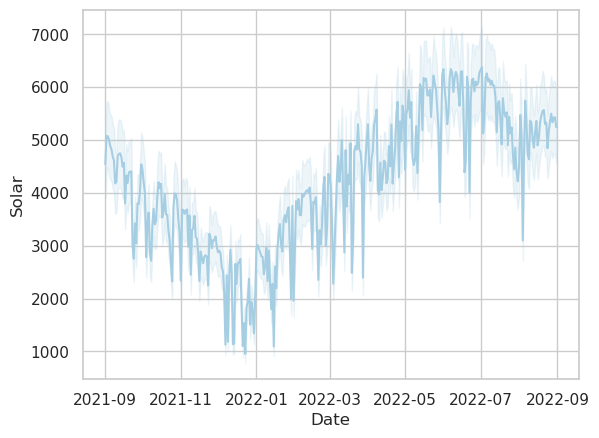

In [171]:
sns.lineplot(data=df, x='Date', y='Solar')

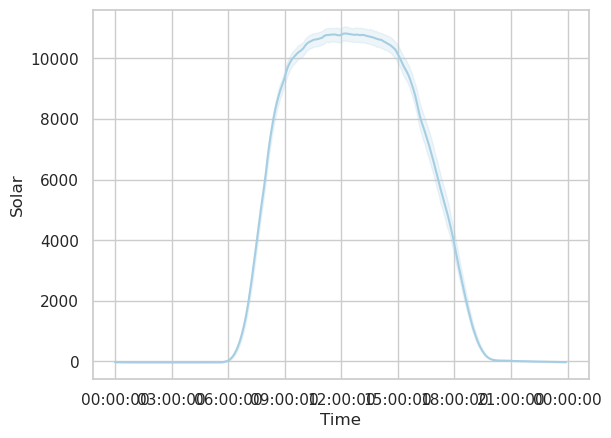

In [172]:
ax = sns.lineplot(data=df, x='Time', y='Solar')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.show()

In [173]:
df_reshaped = pd.concat((df[other] for i in range(len(power_sources)+1)))
df_reshaped['Source'] = pd.concat((pd.Series(np.repeat(ps, df.shape[0])) for ps in power_sources+['Total power']))
df_reshaped['Power (MW)'] = pd.concat((df[ps] for ps in power_sources+['Total power']))
df_reshaped['new_index'] = [i for i in range(df_reshaped.shape[0])]
df_reshaped = df_reshaped.set_index('new_index')
df_reshaped.describe()

,Month,Year,Power (MW)
count,1.366352e+06,1.366352e+06,1.366196e+06
mean,6.526374e+00,2.021666e+03,4.007502e+03
std,3.447980e+00,4.717445e-01,7.242945e+03
min,1.000000e+00,2.021000e+03,-4.459000e+03
25%,4.000000e+00,2.021000e+03,2.010000e+02
50%,7.000000e+00,2.022000e+03,8.870000e+02
75%,1.000000e+01,2.022000e+03,3.874000e+03
max,1.200000e+01,2.022000e+03,4.667900e+04


In [174]:
argsort = df_reshaped.groupby('Source').mean(numeric_only=True)['Power (MW)'].argsort().values[::-1]
hue_order = np.array(df_reshaped.groupby('Source').mean(numeric_only=True)['Power (MW)'][argsort].index)
# pal = np.concatenate(([[0,0,0]], np.array(sns.color_palette('Paired', len(hue_order)-1))))
pal = np.array(sns.color_palette('husl', len(hue_order)))[argsort]
pal[0] = np.array([0,0,0])

/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


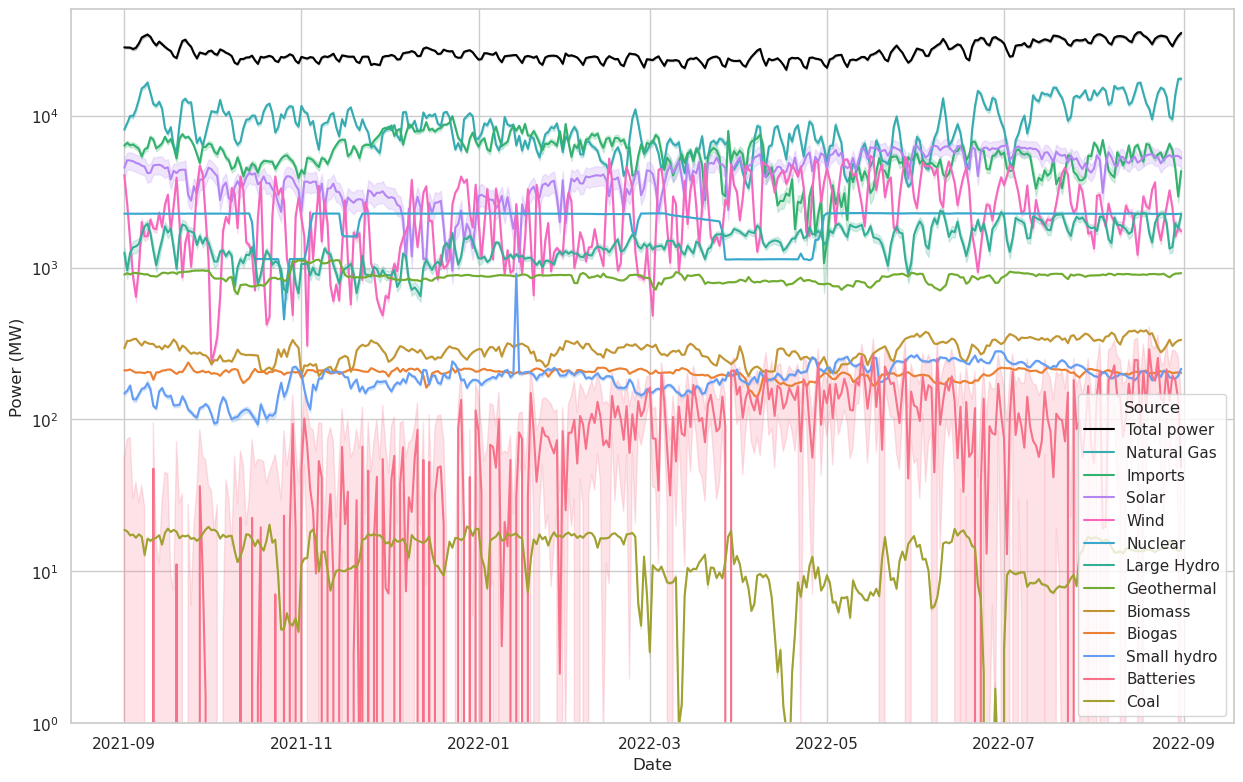

In [175]:
fig, ax = plt.subplots(figsize=(15,15/scipy.constants.golden))
ax = sns.lineplot(ax=ax, data=df_reshaped, x='Date', y='Power (MW)', hue='Source', palette=pal, hue_order=hue_order)
ax.set(yscale='log')
ax.set_ylim([1,5e4])
plt.show()

/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


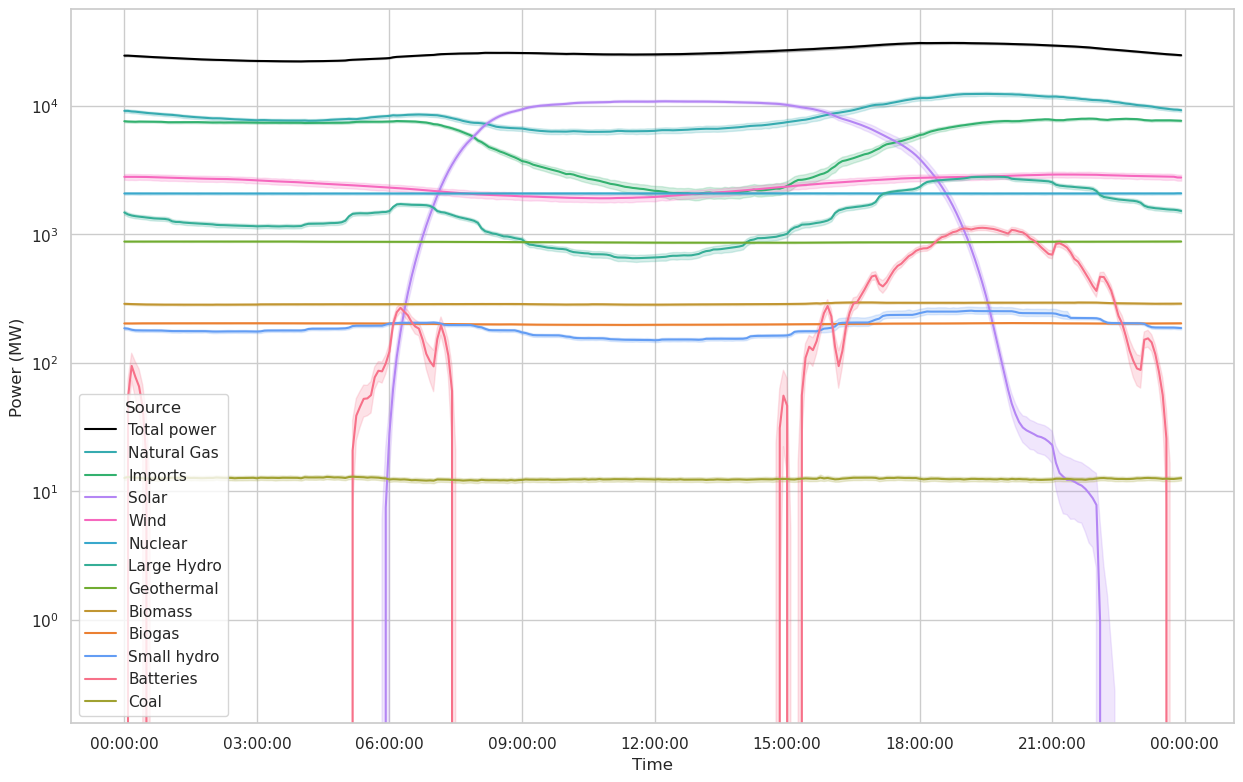

In [176]:
fig, ax = plt.subplots(figsize=(15,15/scipy.constants.golden))
ax = sns.lineplot(ax=ax, data=df_reshaped, x='Time', y='Power (MW)', hue='Source', palette=pal, hue_order=hue_order)
ax.set(yscale='log')
# ax.set_ylim([1,5e4])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.show()